In [1]:
# !pip install easydict
# !pip install tensorboardX
# !pip install shapely
# !pip install torchsummary 

In [2]:
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.models as models

import torch.backends.cudnn as cudnn

import warnings
warnings.filterwarnings("ignore")

import os
import time
import argparse
from datetime import datetime

import torch.utils.data as data
from torch.optim import lr_scheduler
from util.shedule import FixLR

from dataset.total_text import TotalText
from dataset.synth_text import SynthText

from util.augmentation import BaseTransform, Augmentation
from util.config import config as cfg, update_config, print_config
from util.misc import AverageMeter
from util.misc import mkdirs, to_device
from util.option import BaseOptions
from util.visualize import visualize_network_output
from util.summary import LogSummary

from easydict import EasyDict
import matplotlib.pyplot as plt

import torch.multiprocessing as mp
from torchvision import models
from torchsummary import summary

warnings.filterwarnings("ignore", message="indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)")

In [3]:
torch.cuda.empty_cache()

import gc
gc.collect()

0

In [23]:
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()

        # Localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 124 * 124)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        return x

In [24]:
  
    
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, bias=False):
        super(DepthwiseSeparableConv, self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, dilation=dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, rates=[3, 9, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_blocks = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            DepthwiseSeparableConv(in_channels, out_channels, 3, rates[0], rates[0], bias=False),
            DepthwiseSeparableConv(in_channels, out_channels, 3, rates[1], rates[1], bias=False),
            DepthwiseSeparableConv(in_channels, out_channels, 3, rates[2], rates[2], bias=False),
            DepthwiseSeparableConv(in_channels, out_channels, 3, rates[3], rates[3], bias=False)
        ])

        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, 1, bias=False)
        )

        self.output_conv = nn.Conv2d(out_channels * (len(rates) + 2), out_channels, 1, bias=False)

    def forward(self, x):
        x_aspp = [aspp_block(x) for aspp_block in self.aspp_blocks]

        # Apply global average pooling and upsample to match other feature maps
        gap = self.global_avg_pool(x)
        gap = F.interpolate(gap, size=x_aspp[0].shape[2:], mode='bilinear', align_corners=False)

        x_aspp.append(gap)

        x = torch.cat(x_aspp, dim=1)
        x = self.output_conv(x)

        return x




In [25]:
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        base_model = resnet50(pretrained=pretrained)
        
        self.base_layers = list(base_model.children())
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, h/2, w/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, h/4, w/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, h/8, w/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, h/16, w/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, h/32, w/32)
        
        self.aspp = ASPP(2048, 1024)

    def forward(self, x):
        C1 = self.layer0(x)
        C2 = self.layer1(C1)
        C3 = self.layer2(C2)
        C4 = self.layer3(C3)
        C5 = self.layer4(C4)
        
        #Apply ASPP at stage 5
        C5 = self.aspp(C5)
        
        return C1, C2, C3, C4, C5

    
# input = torch.randn((4, 3, 512, 512))
# net = ResNet50()

# C1, C2, C3, C4, C5 = net(input)
# print(C1.size())
# print(C2.size())
# print(C3.size())
# print(C4.size())
# print(C5.size())

In [26]:
class Upsample(nn.Module):

    def __init__(self, in_channels, shortcut_channels, out_channels):
        super().__init__()
        self.conv1x1 = nn.Conv2d(in_channels + shortcut_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.deconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, upsampled, shortcut):
        upsampled = F.interpolate(upsampled, size=(shortcut.size(2), shortcut.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat([upsampled, shortcut], dim=1)
        x = self.conv1x1(x)
        x = F.relu(x)
        x = self.conv3x3(x)
        x = F.relu(x)
        x = self.deconv(x)
        return x

    

class TextNet(nn.Module):

    def __init__(self, backbone='resnet', output_channel=7, is_training=True):
        super().__init__()

        self.is_training = is_training
        self.backbone_name = backbone
        self.output_channel = output_channel
        
        self.stn = STN()
        
        if backbone == 'resnet':
            self.backbone = ResNet50(pretrained=self.is_training)

            self.deconv5 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
            self.merge4 = Upsample(512, 1024, 256)
            self.merge3 = Upsample(256, 512, 128)
            self.merge2 = Upsample(128, 256, 64)
            self.merge1 = Upsample(64, 64, 32)
        

            self.predict = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(32, self.output_channel, kernel_size=1, stride=1, padding=0)
            )
        
    def forward(self, x):
        x = self.stn(x)
        C1, C2, C3, C4, C5 = self.backbone(x)
        up5 = self.deconv5(C5)
        up5 = F.relu(up5)

        up4 = self.merge4(C4, up5)
        up4 = F.relu(up4)

        up3 = self.merge3(C3, up4)
        up3 = F.relu(up3)

        up2 = self.merge2(C2, up3)
        up2 = F.relu(up2)

        up1 = self.merge1(C1, up2)
        output = self.predict(up1)
        
        return output

In [10]:
input = torch.randn((4, 3, 512, 512))
net = TextNet().cuda()
output = net(input.cuda())
print(output.size())



help(summary)
summary(net, (3, 512, 512),4)

torch.Size([4, 7, 512, 512])
Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 506, 506]           1,184
         MaxPool2d-2           [4, 8, 253, 253]               0
              ReLU-3           [4, 8, 253, 253]               0
            Conv2d-4          [4, 10, 249, 249]           2,010
         MaxPool2d-5          [4, 10, 124, 124]               0
              ReLU-6          [4, 10, 124, 124]               0
            Linear-7                    [4, 32]       4,920,352
              ReLU-8                    [4, 32]               0
            Linear-9                     [4, 6]             198
              STN-10           [4, 3, 512, 512]               0
           Conv2d-11          [4, 64, 256, 256]           9,408
      BatchNorm2d

In [27]:
class TextLoss(nn.Module):

    def __init__(self):
        super().__init__()

        
    def ohem(self, predict, target, train_mask, negative_ratio=3.):
        pos = (target * train_mask).bool()
        neg = ((1 - target) * train_mask).bool()

        n_pos = pos.float().sum()

        if n_pos.item() > 0:
            loss_pos = F.cross_entropy(predict[pos], target[pos], reduction='sum')
            loss_neg = F.cross_entropy(predict[neg], target[neg], reduction='none')
            
            n_neg = min(int(neg.float().sum().item()), int(negative_ratio * n_pos.float()))
        else:
            loss_pos = torch.tensor(0.).to(predict.device)
            loss_neg = F.cross_entropy(predict[neg], target[neg].long(), reduction='none')
                        
            n_neg = 100
        loss_neg, _ = torch.topk(loss_neg, n_neg)

        return (loss_pos + loss_neg.sum()) / (n_pos + n_neg).float()

    
    def forward(self, input, tr_mask, tcl_mask, sin_map, cos_map, radii_map, train_mask):
        tr_pred = input[:, :2].permute(0, 2, 3, 1).contiguous().view(-1, 2)
        tcl_pred = input[:, 2:4].permute(0, 2, 3, 1).contiguous().view(-1, 2)
        sin_pred = input[:, 4].contiguous().view(-1)
        cos_pred = input[:, 5].contiguous().view(-1)

        scale = torch.sqrt(1.0 / (sin_pred ** 2 + cos_pred ** 2))
        sin_pred = sin_pred * scale
        cos_pred = cos_pred * scale

        radii_pred = input[:, 6].contiguous().view(-1)

        batch_size = tr_pred.size(0)
        height, width = tr_mask.size(-2), tr_mask.size(-1)

        train_mask = train_mask.view(-1)
        tr_mask = tr_mask.view(-1)
        tcl_mask = tcl_mask.view(-1)
        sin_map = sin_map.view(-1)
        cos_map = cos_map.view(-1)
        radii_map = radii_map.view(-1)

        loss_tr = self.ohem(tr_pred, tr_mask, train_mask)
        

        loss_tcl = 0.
        tr_train_mask = train_mask * tr_mask
        if tr_train_mask.sum().item() > 0:
            loss_tcl = F.cross_entropy(tcl_pred[tr_train_mask], tcl_mask[tr_train_mask].long())

        loss_radii, loss_sin, loss_cos = 0., 0., 0.
        tcl_train_mask = train_mask * tcl_mask
        if tcl_train_mask.sum().item() > 0:
            ones = radii_map.new(radii_pred[tcl_train_mask].size()).fill_(1.).float()
            loss_radii = F.smooth_l1_loss(radii_pred[tcl_train_mask] / radii_map[tcl_train_mask], ones)
            loss_sin = F.smooth_l1_loss(sin_pred[tcl_train_mask], sin_map[tcl_train_mask])
            loss_cos = F.smooth_l1_loss(cos_pred[tcl_train_mask], cos_map[tcl_train_mask])

        return loss_tr, loss_tcl, loss_radii, loss_sin, loss_cos

In [28]:
lr=None
train_step=0

def save_model(model, epoch, lr, optimzer):

    save_dir = os.path.join(cfg.save_dir, cfg.exp_name)
    if not os.path.exists(save_dir):
        mkdirs(save_dir)

    save_path = os.path.join(save_dir, 'textsnake_{}_{}.pth'.format(model.backbone_name, epoch))
    print('Saving to {}.'.format(save_path))
    state_dict = {
        'lr': lr,
        'epoch': epoch,
        'model': model.state_dict() if not cfg.mgpu else model.module.state_dict(),
        'optimizer': optimzer.state_dict()
    }
    torch.save(state_dict, save_path)

In [29]:
def load_model(model, model_path):
    print('Loading from {}'.format(model_path))
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model'])

In [30]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Losses")
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [31]:
def train(model, train_loader, criterion, scheduler, optimizer, epoch, logger):

    global train_step

    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    end = time.time()
    model.train()
    scheduler.step()

    print('Epoch: {} : LR = {}'.format(epoch, lr))

    for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(train_loader):
        data_time.update(time.time() - end)

        train_step += 1

        img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)
        
        output = model(img)
        tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
            criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
        loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.update(loss.item())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if cfg.viz and i % cfg.viz_freq == 0:
            visualize_network_output(output, tr_mask, tcl_mask, mode='train')

        if i % cfg.display_freq == 0:
            print('({:d} / {:d}) - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                i, len(train_loader), loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(), cos_loss.item(), radii_loss.item())
            )

        if i % cfg.log_freq == 0:
            logger.write_scalars({
                'loss': loss.item(),
                'tr_loss': tr_loss.item(),
                'tcl_loss': tcl_loss.item(),
                'sin_loss': sin_loss.item(),
                'cos_loss': cos_loss.item(),
                'radii_loss': radii_loss.item()
            }, tag='train', n_iter=train_step)

    if epoch % cfg.save_freq == 0:
        save_model(model, epoch, scheduler.get_lr(), optimizer)

    print('Training Loss: {}'.format(losses.avg))
    return losses.avg

In [12]:
def validation(model, valid_loader, criterion, epoch, logger):
    
    with torch.no_grad():
        model.eval()
        losses = AverageMeter()
        tr_losses = AverageMeter()
        tcl_losses = AverageMeter()
        sin_losses = AverageMeter()
        cos_losses = AverageMeter()
        radii_losses = AverageMeter()

        for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(valid_loader):

            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
                img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)
            
            output = model(img)

            tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
                criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
            loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

            # update losses
            losses.update(loss.item())
            tr_losses.update(tr_loss.item())
            tcl_losses.update(tcl_loss.item())
            sin_losses.update(sin_loss.item())
            cos_losses.update(cos_loss.item())
            radii_losses.update(radii_loss.item())

            if cfg.viz and i % cfg.viz_freq == 0:
                visualize_network_output(output, tr_mask, tcl_mask, mode='val')

            if i % cfg.display_freq == 0:
                print(
                    'Validation: - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                        loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(),
                        cos_loss.item(), radii_loss.item())
                )

        logger.write_scalars({
            'loss': losses.avg,
            'tr_loss': tr_losses.avg,
            'tcl_loss': tcl_losses.avg,
            'sin_loss': sin_losses.avg,
            'cos_loss': cos_losses.avg,
            'radii_loss': radii_losses.avg
        }, tag='val', n_iter=epoch)

        print('Validation Loss: {}'.format(losses.avg))
        return losses.avg       

In [13]:
def main():
    
    if mp.get_start_method(allow_none=True) != 'spawn':
        mp.set_start_method('spawn', force=True)
        
    train_losses = []
    val_losses = []
        
    global lr
    print(cfg.dataset)
    
    if cfg.dataset == 'total-text':

        trainset = TotalText(
            data_root='data/total-text',
            ignore_list=None,
            is_training=True,
            transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
        )

        valset = TotalText(
            data_root='data/total-text',
            ignore_list=None,
            is_training=False,
            transform=BaseTransform(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
        )

    elif cfg.dataset == 'synth-text':
        trainset = SynthText(
            data_root='data/SynthText',
            is_training=True,
            transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
        )
        valset = None
    else:
        pass

    train_loader = data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    if valset:
        val_loader = data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    else:
        valset = None

    log_dir = os.path.join(cfg.log_dir, datetime.now().strftime('%b%d_%H-%M-%S_') + cfg.exp_name)
    logger = LogSummary(log_dir)

    # Model
    model = TextNet(is_training=True, backbone='resnet', output_channel=7)
        
    if cfg.mgpu:
        model = nn.DataParallel(model)

    model = model.to(cfg.device)

    
    if cfg.cuda:
        cudnn.benchmark = True

    if cfg.resume:
        load_model(model, cfg.resume)

    criterion = TextLoss()
    lr = cfg.lr
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    if cfg.dataset == 'synth-text':
        scheduler = FixLR(optimizer)
    else:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    print('Start training TextSnake.')
    
    for epoch in range(cfg.start_epoch, cfg.max_epoch):
        # train(model, train_loader, criterion, scheduler, optimizer, epoch, logger)
        train_loss=train(model, train_loader, criterion, scheduler, optimizer, epoch, logger)
        train_losses.append(train_loss)
        
        if valset:
            # validation(model, val_loader, criterion, epoch, logger)
            val_loss=validation(model, val_loader, criterion, epoch, logger)
            val_losses.append(val_loss)
            
    print('End.')
    
    plot_losses(train_losses, val_losses)

total-text
==========Options============
num_workers: 8
batch_size: 4
max_epoch: 201
start_epoch: 0
lr: 0.0001
cuda: True
n_disk: 15
output_dir: output
input_size: 512
max_annotation: 200
max_points: 20
use_hard: True
tr_thresh: 0.6
tcl_thresh: 0.4
post_process_expand: 0.3
post_process_merge: False
dataset: total-text
device: cuda
vis_dir: ./vis/
save_dir: ./save/
data_custom: False
data_root: data/total-text
exp_name: resnet_ASPP_LATE_2
net: resnet
resume: None
mgpu: False
log_dir: ./logs/
loss: CrossEntropyLoss
input_channel: 1
pretrain: False
verbose: True
viz: True
start_iter: 0
lr_adjust: fix
stepvalues: []
weight_decay: 0.0
gamma: 0.1
momentum: 0.9
optim: SGD
display_freq: 50
viz_freq: 50
save_freq: 50
log_freq: 100
val_freq: 100
rescale: 255.0
means: [0.485, 0.456, 0.406]
stds: [0.229, 0.224, 0.225]
checkepoch: -1
img_root: None
=============End=============
total-text
Start training TextSnake.
Epoch: 0 : LR = 0.0001
(0 / 314) - Loss: 2.8558 - tr_loss: 0.6819 - tcl_loss: 0.7107 

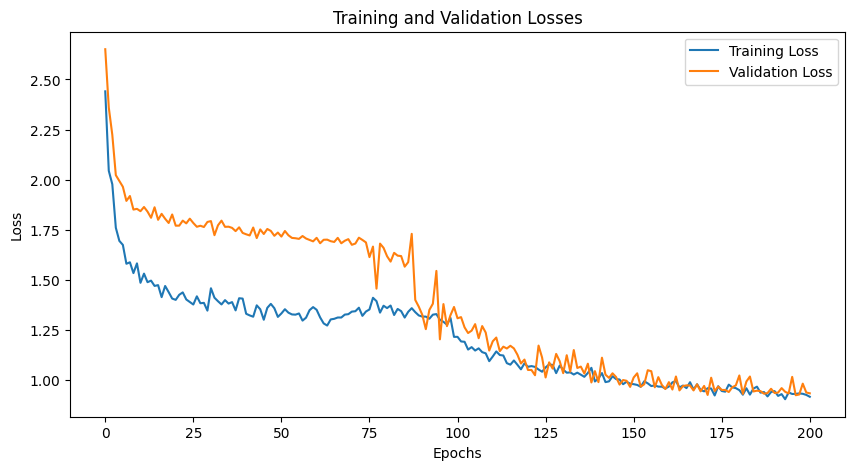

In [14]:
option = BaseOptions()
command_line_args = ["resnet_ASPP_LATE_2", "--viz", "--net", "resnet", "--cuda", "True"]


args = option.initialize(command_line_args)


update_config(cfg, args)
print_config(cfg)


main()

In [32]:
import os
import time
import cv2
import numpy as np
import torch
import subprocess
import torch.backends.cudnn as cudnn
import torch.utils.data as data

import multiprocessing

from util.detection import TextDetector
from util.augmentation import BaseTransform
from util.option import BaseOptions
from util.visualize import visualize_detection
from util.misc import rescale_result

from torchvision.ops import nms
from sklearn.cluster import DBSCAN
from util.config import config as cfg
from util.misc import fill_hole, regularize_sin_cos
from util.misc import norm2, vector_cos, vector_sin
from util.misc import disjoint_merge, merge_polygons

In [33]:
def write_to_file(contours, file_path):
    # according to total-text evaluation method, output file shoud be formatted to: y0,x0, ..... yn,xn
    with open(file_path, 'w') as f:
        for cont in contours:
            cont = np.stack([cont[:, 1], cont[:, 0]], 1)
            cont = cont.flatten().astype(str).tolist()
            cont = ','.join(cont)
            f.write(cont + '\n')

In [34]:
def inference(detector, test_loader, output_dir):
    total_time = 0.

    for i, (image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(test_loader):

        image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
            image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)

        torch.cuda.synchronize()
        start = time.time()

        idx = 0 # test mode can only run with batch_size == 1

        # get detection result
        contours, output = detector.detect(image)

        torch.cuda.synchronize()
        end = time.time()
        total_time += end - start
        fps = (i + 1) / total_time
        print('detect {} / {} images: {}. ({:.2f} fps)'.format(i + 1, len(test_loader), meta['image_id'][idx], fps))

        # visualization
        tr_pred, tcl_pred = output['tr'], output['tcl']
        img_show = image[idx].permute(1, 2, 0).cpu().numpy()
        img_show = ((img_show * cfg.stds + cfg.means) * 255).astype(np.uint8)

        pred_vis = visualize_detection(img_show, contours, tr_pred[1], tcl_pred[1])
        gt_contour = []
        for annot, n_annot in zip(meta['annotation'][idx], meta['n_annotation'][idx]):
            if n_annot.item() > 0:
                gt_contour.append(annot[:n_annot].int().cpu().numpy())
        gt_vis = visualize_detection(img_show, gt_contour, tr_mask[idx].cpu().numpy(), tcl_mask[idx].cpu().numpy())
        im_vis = np.concatenate([pred_vis, gt_vis], axis=0)
        path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name), meta['image_id'][idx])
        cv2.imwrite(path, im_vis)

        H, W = meta['Height'][idx].item(), meta['Width'][idx].item()
        img_show, contours = rescale_result(img_show, contours, H, W)

        # write to file
        mkdirs(output_dir)
        write_to_file(contours, os.path.join(output_dir, meta['image_id'][idx].replace('jpg', 'txt')))

In [35]:
def main():     
    if multiprocessing.get_start_method(allow_none=True) is None:
        multiprocessing.set_start_method('spawn')
    
    testset = TotalText(
        # data_root='data/total-text',
        data_root=cfg.data_root,
        ignore_list=None,
        is_training=False,
        transform=BaseTransform(size=cfg.input_size, mean=cfg.means, std=cfg.stds),
        data_custom=cfg.data_custom
    )
    test_loader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=cfg.num_workers)

    # Model
    model = TextNet(is_training=False, backbone=cfg.net)
    model_path = os.path.join(cfg.save_dir, cfg.exp_name, \
              'textsnake_{}_{}.pth'.format(model.backbone_name, cfg.checkepoch))
    load_model(model,model_path)

    # copy to cuda
    model = model.to(cfg.device)
    if cfg.cuda:
        cudnn.benchmark = True
    detector = TextDetector(model, tr_thresh=cfg.tr_thresh, tcl_thresh=cfg.tcl_thresh)

    print('Start testing TextSnake.')
    output_dir = os.path.join(cfg.output_dir, cfg.exp_name)
    inference(detector, test_loader, output_dir)

    # compute DetEval
    print('Computing DetEval in {}/{}'.format(cfg.output_dir, cfg.exp_name))
    subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', args.exp_name, '--tr', '0.6', '--tp', '0.4'])
    subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', args.exp_name, '--tr', '0.8', '--tp', '0.4'])
    # subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', args.exp_name, '--tr', '0.6', '--tp', '0.4'])
    # subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', args.exp_name, '--tr', '0.6', '--tp', '0.6'])

    print('End.')

In [36]:
# parse arguments
option = BaseOptions()

command_line_args = ["resnet_ASPP_LATE_2", "--net", "resnet", "--checkepoch", "150", "--data_root", "data/total-text", "--img_root", "data/total-text"]  
args = option.initialize(command_line_args)

update_config(cfg, args)
print_config(cfg)

vis_dir = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name))
if not os.path.exists(vis_dir):
    mkdirs(vis_dir)
# main
main()

total-text
==========Options============
num_workers: 8
batch_size: 4
max_epoch: 201
start_epoch: 0
lr: 0.0001
cuda: True
n_disk: 15
output_dir: output
input_size: 512
max_annotation: 200
max_points: 20
use_hard: True
tr_thresh: 0.6
tcl_thresh: 0.4
post_process_expand: 0.3
post_process_merge: False
dataset: total-text
device: cuda
vis_dir: ./vis/
save_dir: ./save/
data_custom: False
data_root: data/total-text
exp_name: resnet_ASPP_LATE_2
net: resnet
resume: None
mgpu: False
log_dir: ./logs/
loss: CrossEntropyLoss
input_channel: 1
pretrain: False
verbose: True
viz: False
start_iter: 0
lr_adjust: fix
stepvalues: []
weight_decay: 0.0
gamma: 0.1
momentum: 0.9
optim: SGD
display_freq: 50
viz_freq: 50
save_freq: 50
log_freq: 100
val_freq: 100
rescale: 255.0
means: [0.485, 0.456, 0.406]
stds: [0.229, 0.224, 0.225]
checkepoch: 150
img_root: data/total-text
=============End=============
Loading from ./save/resnet_ASPP_LATE_2/textsnake_resnet_150.pth
Start testing TextSnake.
detect 1 / 300 image

  0%|          | 0/301 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 12%|█▏        | 36/301 [00:03<00:22, 11.85it/s]/notebooks/dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py:78: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (gt[5] == '#') and (gt[1].shape[1] > 1):
/notebooks/dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py:134: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  dc_id = np.where(groundtruths[:, 5] == '#')
100%|██████████| 301/301 [00:34<00:00,  8.70it/s]


Skipped directory .ipynb_checkpoints
Input: output/resnet_ASPP_LATE_2
Config: tr: 0.6 - tp: 0.4
Precision = 0.8947 - Recall = 0.5797 - Fscore = 0.7035

Done.


  0%|          | 0/301 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 12%|█▏        | 36/301 [00:03<00:21, 12.14it/s]/notebooks/dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py:78: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (gt[5] == '#') and (gt[1].shape[1] > 1):
/notebooks/dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py:134: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  dc_id = np.where(groundtruths[:, 5] == '#')
 98%|█████████▊| 295/301 [00:31<00:00, 18.96it/s]

Skipped directory .ipynb_checkpoints
Input: output/resnet_ASPP_LATE_2
Config: tr: 0.8 - tp: 0.4
Precision = 0.8505 - Recall = 0.5553 - Fscore = 0.6719

Done.
End.


100%|██████████| 301/301 [00:31<00:00,  9.44it/s]
